In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
df = pd.read_csv('../data/chr1.S15-30.filtered.csv', index_col=0, dtype='int').reset_index(drop=True)
df.shape

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6743736, 4)

In [3]:
uplifted = pd.read_csv('../data/peaks.min_peak_score_0.6.thresh_0.5.csv', index_col=0)
# uplifted.drop('Unnamed: 0', inplace=True, axis=1)
uplifted = uplifted[uplifted.chrom == 'chr1'].copy()


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
def make_n_bp(df, uplifted, n=70):
    """
Return all 'df' elements where end in range n before start of 'uplifted'
    :param n: max number of bp from df.end to uplifted.start
    :param df: sec. struct. df with columns start   end len_stem    len_loop (10941426 rows)
    :param uplifted: nucleosome df with columns chrom   start   end peak_pos    score (1037956 rows)
    """
    df1 = df.sort_values('end').reset_index(drop=True)
    # getting indexes where should df.end be, if inserted into uplifted
    indexes = np.searchsorted(uplifted.start.values, df1.end.values)
    uplifted1 = uplifted.append(uplifted.tail(1))  # for df.end > uplifted.start.max()
    uplifted_ind = uplifted1.iloc[indexes].reset_index(drop=True)  # getting all uplifted.start closest to df.end
    uplifted_ind['df_end'] = df1.end.values
    uplifted_ind['diff'] = uplifted_ind.start - uplifted_ind.df_end
    mask = (uplifted_ind['diff'] >= 0) & (uplifted_ind['diff'] < n)
    return df1[mask].reset_index(drop=True)
ss70bp = make_n_bp(df, uplifted)

In [5]:
ss70bp.shape[0]/df.shape[0]

0.02479945834178562

In [11]:
def render_mpl_table(data, title='test', col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    fig.suptitle(title, fontsize=15)

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    import six
    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

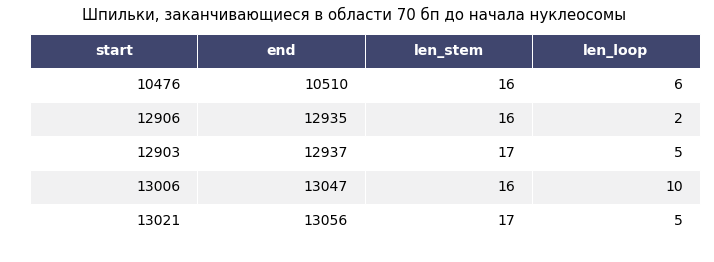

In [28]:
ax = render_mpl_table(ss70bp.head(), title='Шпильки, заканчивающиеся в области 70 бп до начала нуклеосомы')
plt.savefig('../pictures/ss70bp.png', dpi=300)
plt.savefig('../epses/ss70bp.eps', format='eps', dpi=1000)

In [ ]:
def make_go_terms(ss10bp, suffix='quad'):
    """
makes go_terms.csv for pasting to http://revigo.irb.hr/ and getting genes and their types
also makes relevant_goa_names.csv for names of this genes
    """
    ptt = pd.read_csv('../data/ptt_hg19.txt', delimiter='\t')
    ptt1 = ptt[ptt['chrom'] == 'chr1']

    def make_10bp_pr(df, uplifted):
        arr_4_rows = []
        for start_upl in tqdm(pd.to_numeric(uplifted.end)):
            temp_df = df[(df['txStart'] - 1000 < start_upl) & (df['txEnd'] > start_upl)]
            if not temp_df.empty:
                for ind, row in temp_df.iterrows():
                    arr_4_rows.append(row)
        return pd.DataFrame(arr_4_rows)

    relevant_ptt = make_10bp_pr(ptt1, ss10bp)

    goa = pd.read_csv('../data/goa_human.gaf', delimiter='\t', header=None)

    relevant_goa = goa[goa[1].isin(relevant_ptt.proteinID)].drop_duplicates(1).drop_duplicates(4).drop_duplicates(9)
    relevant_goa[9].to_csv('../data/relevant_goa_names_{}.csv'.format(suffix))
    relevant_goa[4].to_csv('../data/go_terms_{}.csv'.format(suffix), index=False)
    return relevant_goa, relevant_ptt 
relevant_goa, relevant_ptt = make_go_terms(ss70bp, 'ss70bp')

In [51]:
relevant_goa.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1996,UniProtKB,A0PJX8,TMEM82,NaN,GO:0016021,GO_REF:0000037,IEA,UniProtKB-KW:KW-0812,C,Transmembrane protein 82,TMM82_HUMAN|TMEM82,protein,taxon:9606,20171216,UniProt,NaN,NaN
2231,UniProtKB,A1L453,PRSS38,NaN,GO:0004252,GO_REF:0000002,IEA,InterPro:IPR001254|InterPro:IPR001314|InterPro...,F,Serine protease 38,PRS38_HUMAN|PRSS38|MPN2,protein,taxon:9606,20171216,InterPro,NaN,NaN
2460,UniProtKB,A2PYH4,HFM1,NaN,GO:0000712,GO_REF:0000107,IEA,UniProtKB:D3Z4R1|ensembl:ENSMUSP00000108310,P,Probable ATP-dependent DNA helicase HFM1,HFM1_HUMAN|HFM1|SEC3D1,protein,taxon:9606,20171216,Ensembl,NaN,NaN
2556,UniProtKB,A2RUH7,MYBPHL,NaN,GO:0003674,GO_REF:0000015,ND,NaN,F,Myosin-binding protein H-like,MBPHL_HUMAN|MYBPHL,protein,taxon:9606,20090327,BHF-UCL,NaN,NaN
2587,UniProtKB,A2VCK2,DCDC2B,NaN,GO:0005515,PMID:25416956,IPI,UniProtKB:Q13643,F,Doublecortin domain-containing protein 2B,DCD2B_HUMAN|DCDC2B,protein,taxon:9606,20171218,IntAct,NaN,NaN


In [8]:
def add_bp_according2_start_end(neg_example):
    """
adds nucleotides string according to start-end columns
    :param neg_example: DataFrame with start-end columns
    """
    from Bio import SeqIO
    first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

    temp = pd.DataFrame(np.ndarray((neg_example.shape[0], 4)),
                        columns=["struct", "before", "after", 'half_struct'], dtype='str')
    for idx, row in neg_example.iterrows():
        temp.loc[idx][0] = first_record[row['start']:row['end']]
        temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
        temp.loc[idx][2] = first_record[row['end']:row['end']    + 20]
        temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

    return pd.concat([neg_example, temp], axis=1)
concated =  add_bp_according2_start_end(ss70bp)

In [9]:
def make_neg_example_and_concat(df, quad10with_bps):
    """
    :param df: DataFrame with start-end coordinates
    :param quad10with_bps: second DataFrame to be concated (ie ss10bp)
    :return: concated df for feature calculations
    """
    neg_example = df.sample(5000).reset_index(drop=True)
    neg_example = add_bp_according2_start_end(neg_example)
    neg_example['value'] = 0
    quad10with_bps['value'] = 1
    concated = pd.concat([neg_example, quad10with_bps])
    return concated

concated = make_neg_example_and_concat(df, concated)

In [13]:
def calc_feats(concated, position='half_struct'):
    """
calculate features from diprodb
    :param position: struct, before, after or half_struct
    :param concated: df with bp as after add_bp_according2_start_end
    """
    diprodb = pd.read_csv('../data/dprops.csv', index_col=0)
    import re
    features = []
    for struct in tqdm(concated.loc[:, concated.columns != 'value'][position]):
        strl = re.findall('..', struct)
        temp = []
        for dyad in strl:
            temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
        features.append(pd.DataFrame(temp, columns=diprodb.columns).sum())
    return pd.DataFrame(features)

features = calc_feats(concated)

HBox(children=(IntProgress(value=0, max=172241), HTML(value='')))

In [15]:
features.to_csv('feats70.csv', index_label=False)

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 117096, number of negative: 3472
[LightGBM] [Info] Total Bins 29087
[LightGBM] [Info] Number of data: 120568, number of used features: 125
[LightGBM] [Info] using GOSS
[1]	valid_0's auc: 0.573315
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.579112
[3]	valid_0's auc: 0.578547
[4]	valid_0's auc: 0.576841
[5]	valid_0's auc: 0.577787
[6]	valid_0's auc: 0.577496
[7]	valid_0's auc: 0.577868
[8]	valid_0's auc: 0.579151
[9]	valid_0's auc: 0.579724
[10]	valid_0's auc: 0.579916
[11]	valid_0's auc: 0.579983
[12]	valid_0's auc: 0.580529
[13]	valid_0's auc: 0.581122
[14]	valid_0's auc: 0.580154
[15]	valid_0's auc: 0.58055
[16]	valid_0's auc: 0.581113
[17]	valid_0's auc: 0.58188
[18]	valid_0's auc: 0.583085
[19]	valid_0's auc: 0.58237
[20]	valid_0's auc: 0.581482
[21]	valid_0's auc: 0.581949
[22]	valid_0's auc: 0.582045
[23]	valid_0's auc: 0.582044
[24]	valid_0's auc: 0.58199
[25]	valid_0's auc: 0.58193
[26]	valid_0's auc: 0

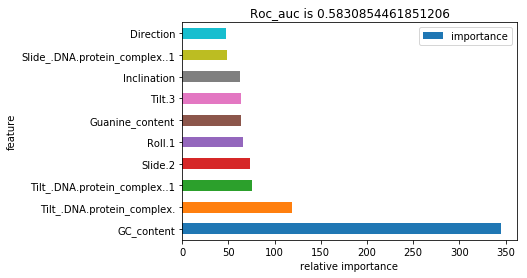

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
%load_ext wurlitzer
# c++ output to jupyter
# import telepyth  # push notif in telegram
# %telepyth - t 1260389131217015787


def lgbm(feats, concated):
    """
fit lgbm with default params
    :param feats: DataFrame to be splitted and fitted
    :param concated: from this Dataframe target is taken
    :return: model and plt for plt.show()
    """
    x_train, x_test, y_train, y_test = train_test_split(
        feats.drop('PropertyName', axis=1).values, concated['value'].values,
        test_size=0.3)


    import lightgbm as lgb
    from sklearn.metrics import roc_auc_score
    np.random.seed(42)
    params = {
    #     "max_bin": 1024,
    #     "learning_rate": 0.01,
        "boosting_type": "goss",
        "objective": "binary",
    #     'num_iterations':10000,
        "metric": "auc",
    #     "num_leaves": 10000,
        "verbose": 1,
    #     "min_data": 100,
    #     "boost_from_average": True,
        'early_stopping_round': 50
    }

    d_train = lgb.Dataset(x_train, y_train)
    d_valid = lgb.Dataset(x_test, label=y_test)
    model = lgb.train(params, d_train, valid_sets=d_valid)
    # model.save_model('lgbm')
    # model = lgb.Booster(model_file='lgbm')

    y_pred = model.predict(x_test)
    print(roc_auc_score(y_test, y_pred))
    def plot_feat_import(features, model, y_test, y_pred):
        from sklearn.metrics import roc_auc_score
        df_fi = pd.DataFrame(features.columns[1:], columns=['feature'])
        df_fi['importance'] = list(model.feature_importance('gain'))
        df_fi.sort_values('importance', ascending=False, inplace=True)
        # print(df_fi)
        plt.figure()
        df_fi.head(10).plot(kind='barh', x='feature', y='importance')
        plt.title('Roc_auc is {}'.format(roc_auc_score(y_test, y_pred)))
        plt.xlabel('relative importance')
        return plt
    plot = plot_feat_import(feats, model, y_test, y_pred)
    return model, plot
model, plot = lgbm(features, concated)

In [ ]:
features = pd.read_csv('../data/features_df.csv')

x_train, x_test, y_train, y_test = train_test_split(
        features.drop(['PropertyName', 'target'], axis=1).values, features['target'].values,
        test_size=0.3)


import lightgbm as lgb
from sklearn.metrics import roc_auc_score
np.random.seed(42)
params = {
#     "max_bin": 1024,
#     "learning_rate": 0.01,
    "boosting_type": "goss",
    "objective": "binary",
#     'num_iterations':10000,
    "metric": "auc",
#     "num_leaves": 10000,
    "verbose": 1,
#     "min_data": 100,
#     "boost_from_average": True,
    'early_stopping_round': 50
}

d_train = lgb.Dataset(x_train, y_train)
d_valid = lgb.Dataset(x_test, label=y_test)
model = lgb.train(params, d_train, valid_sets=d_valid)
# model.save_model('lgbm')
# model = lgb.Booster(model_file='lgbm')

0.819758520877117


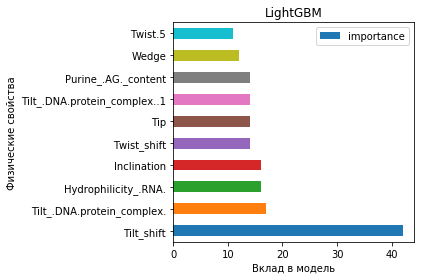

In [55]:
y_pred = model.predict(x_test)
print(roc_auc_score(y_test, y_pred))
# def plot_feat_import(features, model, y_test, y_pred):
from sklearn.metrics import roc_auc_score
df_fi = pd.DataFrame(features.drop('target', axis=1).columns[1:], columns=['feature'])
df_fi['importance'] = list(model.feature_importance())
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
plt.figure()
df_fi.head(10).plot(kind='barh', x='feature', y='importance')
plt.title("LightGBM")
plt.xlabel('Вклад в модель')
plt.ylabel('Физические свойства')
plt.tight_layout()
#     return plt
# plot = plot_feat_import(features.drop('target', axis=1), model, y_test, y_pred)
plt.savefig('../pictures/feat_importance_lgbm.png', dpi=300)
plt.savefig('../epses/feat_importance_lgbm.eps', format='eps', dpi=1000)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict_proba(x_test)

print(roc_auc_score(y_test, y_pred_lr[:, 1]))


/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.7783819486247963


In [44]:
confusion_matrix(y_test, y_pred_lr)

array([[4460,   76],
       [ 691,  311]])